In [1]:
import pandas as pd
import numpy as np
import json
import folium
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly_express as px
from tqdm.notebook import tqdm
import folium.plugins as plugins

## Noise Data

In [2]:
noise_data = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv')
noise_data['Created Date'] = pd.to_datetime(noise_data['Created Date'], format="%m/%d/%Y %I:%M:%S %p")
noise_data['Closed Date'] = pd.to_datetime(noise_data['Closed Date'], format="%m/%d/%Y %I:%M:%S %p")

C:\Users\micha\AppData\Local\Temp\ipykernel_25544\783434488.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  noise_data = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv')


In [3]:
# Define list of construction related descriptors
construction_noise_complains = ['Noise: Construction Before/After Hours (NM1)', 'Noise: Construction Equipment (NC1)', 'Noise: Jack Hammering (NC2)']
noise_data = noise_data[noise_data['Descriptor'].isin(construction_noise_complains)]
# Drop that data that doesn't have Latitude, Longitude fields.
noise_data = noise_data.dropna(subset=['Latitude', 'Longitude'], inplace=False)
print(f"Total number of observations inside construction-noise related data: {len(noise_data)}")

Total number of observations inside construction-noise related data: 31615


## Exploration of Department of Building (DOB) Permit Data.


**Dataset cleaning and preprocessing.**
* To ensure that the data can be loaded efficiently it was necessary to specify the data format for the DateTime fields
* Data analysis revealed that the New York City School Construction Authority is present in the dataset under two different names, that is NYCSCA and NYC SCA. To ensure that the homogeneity of data has been unified.
* Less than 1% of the data didn't have a location value or Owner's Business Name value. As this was crucial for further analysis this data has been removed from the dataset.


In [4]:
path= r"DOB_Permit_Issuance_20240421.csv"
permit_data = pd.read_csv(path)

permit_data['Filing Date'] = pd.to_datetime(permit_data['Filing Date'], format="%m/%d/%Y")
permit_data['Expiration Date'] = pd.to_datetime(permit_data['Expiration Date'], format="%m/%d/%Y")
permit_data['Issuance Date'] = pd.to_datetime(permit_data['Issuance Date'], format="%m/%d/%Y")
permit_data['Job Start Date'] = pd.to_datetime(permit_data['Job Start Date'], format="%m/%d/%Y")
permit_data['Owner\'s Business Name'] = permit_data['Owner\'s Business Name'].replace('NYCSCA', 'NYC SCA')
permit_data = permit_data.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=False)
permit_data = permit_data.dropna(subset=["Owner's Business Name"])

In [5]:
# Total size of DOB permit data
print(f"Number of rows: {permit_data.shape[0]}")
print(f"Number of columns: {permit_data.shape[1]}")

# Other properties
min_date = permit_data['Job Start Date'].min()
max_date = permit_data['Job Start Date'].max()
date_range = max_date - min_date
print(f"Job permits for date range: {date_range.days} days, from {min_date} to {max_date}")

unique_types = permit_data['Permittee\'s Business Name'].nunique()
print(f"Number of unique companies that received permits: {unique_types}")

Number of rows: 5618
Number of columns: 60
Job permits for date range: 360 days, from 2023-01-03 00:00:00 to 2023-12-29 00:00:00
Number of unique companies that received permits: 1148


In [6]:
print(f"Most interesting columns inside the Permit Dataset\n")
print(f"{permit_data[['Job Start Date', 'BOROUGH', 'Job #', 'LATITUDE', 'LONGITUDE']].head()}")

Most interesting columns inside the Permit Dataset

   Job Start Date        BOROUGH      Job #   LATITUDE  LONGITUDE
0      2023-11-21       BROOKLYN  321953891  40.681528 -73.957603
8      2023-05-01      MANHATTAN  140978075  40.802610 -73.967694
9      2023-11-21       BROOKLYN  340905220  40.678058 -73.966258
11     2023-12-05  STATEN ISLAND  540261679  40.644123 -74.107826
14     2023-05-01          BRONX  201207853  40.845878 -73.886184


### Load the custom dataset.
Construction of this dataset proved to be computationally expensive as for each construction site it was necessary to check all records from the complaints dataset and find only those that happened in the closest area. For that reason, this operation was done only once using DTU computing resources and the final dataset was saved as a JSON file that can be loaded for further work.

In [7]:
# Read the dictionary from the JSON file
file_name = 'final_results.json'
with open(file_name, 'r') as f:
    complaints_dict = json.load(f)
print(f"Loaded final dict: {file_name}")
print(f"Number of keys: {len(complaints_dict.keys())}")

Loaded final dict: final_results.json
Number of keys: 7071


This custom dataset connects construction site permits with construction site-related noise complaints. As a result, it was possible to retrieve a dictionary object where keys are individual Job # valeus that are assigned to a construction permit when it's issued. Each value assigned to a key is a relevant noise complaint that was made in the close area from where the work was carried out. 

Further exploration led to the creation of a supplementary dictionary that connects individual companies with the whole number of noise complaints that they received. Thanks to that it was possible to find out which construction sites were most problematic and noisy for New York City residents. This dataset was created using below functions. Using this data it was possible to plot the top 15 most complained companies as can be seen in the figure below. 


In [12]:
def map_job_to_owner(complaints_dict, permit_data):
    owner_complaints_dict = {}
    for job_number, values in complaints_dict.items():
        # Get the owner's business name for the current job_number
        owner_name = permit_data.loc[permit_data['Job #'] == int(job_number), "Permittee's Business Name"].iloc[0]
        # Update the new dictionary with the owner's name as key and original values as value
        if owner_name not in owner_complaints_dict:
            owner_complaints_dict[owner_name] = values
        else:
            owner_complaints_dict[owner_name].extend(values)
    return owner_complaints_dict

asdasd = map_job_to_owner(complaints_dict, permit_data)

IndexError: single positional indexer is out-of-bounds

In [11]:
def group_complaints_by_owner(complaints_dict, permit_data):
    
    complaints_by_owner = {}

    for job_number, complaints in complaints_dict.items():
        # Get the owner's business name for the current job_number
        owner_name = permit_data.loc[permit_data['Job #'] == int(job_number), "Permittee's Business Name"].iloc[0]
        
        if owner_name in complaints_by_owner:
            # If the owner's business name exists, append the complaints to its corresponding list
            complaints_by_owner[owner_name].extend(complaints)
        else:
            # If the owner's business name doesn't exist, create a new key-value pair
            complaints_by_owner[owner_name] = complaints.copy()
    
    complaints_by_owner = {k: v for k, v in complaints_by_owner.items() if pd.notna(k)}
    
    return complaints_by_owner

def show_sorted_owner_dict(business_dict, num_keys=20):
    # Sort the keys based on the number of values
    sorted_keys = sorted(business_dict, key=lambda k: len(business_dict[k]), reverse=True)
    
    # Limit the number of keys to show
    sorted_keys = sorted_keys[:num_keys]
    
    for key in sorted_keys:
        num_complaints = len(business_dict[key])
        print(f"Permittee's Business Name: {key}, Number of Complaints: {num_complaints}")


business_dict = group_complaints_by_owner(complaints_dict, permit_data)
# show_sorted_owner_dict(business_dict, num_keys=5)

IndexError: single positional indexer is out-of-bounds

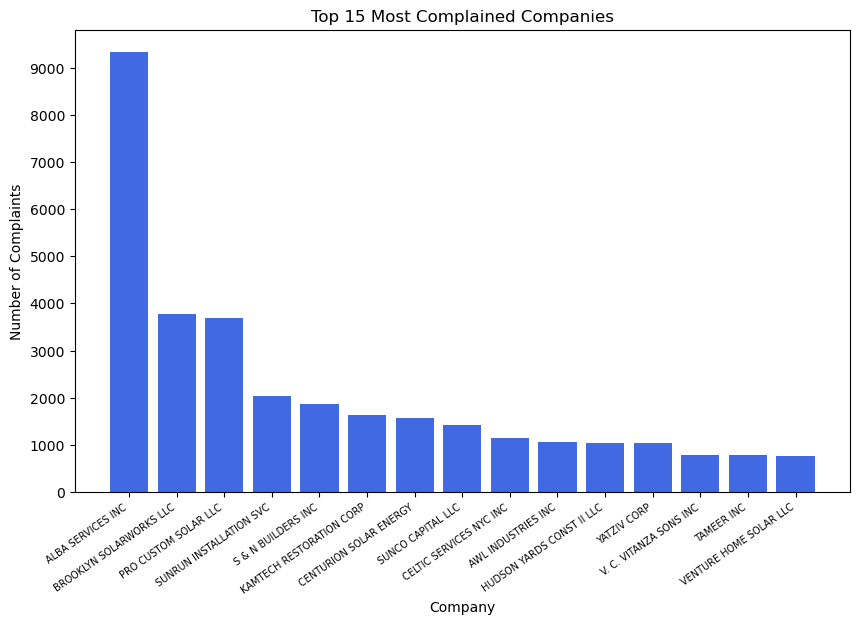

In [38]:
def plot_top_companies(owner_dict, top_n=20, y_steps=10):
    # Sort the dictionary based on the number of values (complaints) for each key (business)
    sorted_owner_dict = {k: v for k, v in sorted(owner_dict.items(), key=lambda item: len(item[1]), reverse=True)}
    
    # Extract the top 20 most popular companies
    top_companies = list(sorted_owner_dict.keys())[:top_n]
    company_counts = [len(sorted_owner_dict[company]) for company in top_companies]
    
    # Convert any non-string values in top_companies to strings
    top_companies = [str(company) for company in top_companies]
    
    # Plot the bar plot with flipped axis
    plt.figure(figsize=(10, 6))
    plt.bar(top_companies, company_counts, color='royalblue')
    plt.ylabel('Number of Complaints')
    plt.xlabel("Company")
    plt.title('Top 15 Most Complained Companies')
    plt.xticks(rotation=35, ha='right',fontsize=7)
    
    # Adjust Y-axis ticks
    max_count = max(company_counts)
    plt.yticks(np.arange(0, max_count+1, y_steps))  # Adjust the number of steps
    
    plt.savefig('top_baddest_companies.png', bbox_inches='tight')
    
    plt.show()

plot_top_companies(business_dict, top_n=15, y_steps=1000)

By leveraging our custom dataset linking construction sites with related noise complaints, we gained insights into the locations that received the highest number of complaints. This information provides valuable visibility into areas of the city that may experience heightened noise levels post-construction hours. To visually present this data, we created a map overlay pinpointing these hotspots, facilitating easy exploration of one's areas of interest. To maintain map clarity and prevent overcrowding, we categorized the noisy areas into three subgroups based on complaint counts. Additionally, construction sites with fewer than 300 complaints in a single year were excluded to enhance map readability and user experience. This view provides more detailed information in comparison to the general noise pollution map that was created earlier. Relevant code for this part can be see below.

In [13]:
def plot_top_complaints_on_map(complaints_dict, permit_data):

    nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

    stamen_toner_url = 'https://tiles.stadiamaps.com/tiles/stamen_toner/{z}/{x}/{y}{r}.png?api_key=dba936f3-1ed1-4864-a3c0-f0b5f0f1ec3d'
    toner_layer = folium.TileLayer(
        tiles=stamen_toner_url,
        attr='Toner Background',
        name='Toner Background',
        max_zoom=18,
        min_zoom=8,
        subdomains='abcd'
    ).add_to(nyc_map)

    colors = {
        'darkred': {'min_complaints': 450, 'range': '450 or more complaints', 'show': True},
        'orange': {'min_complaints': 400, 'max_complaints': 449, 'range': '400-499 complaints', 'show': True},
        'beige': {'min_complaints': 300, 'max_complaints': 400, 'range': '300-400 complaints', 'show': False}
    }

    # Create layer groups for each color
    layer_groups = {}
    for color, info in colors.items():
        range_info = info['range']
        showByDefault = info['show']
        layer_groups[color] = folium.FeatureGroup(name=range_info, overlay=True, show=showByDefault)

    # Iterate over the top X key-value pairs
    for job_number, companies in complaints_dict.items():
        # Look up latitude and longitude values from permit_data based on the Job#
        job_data = permit_data[permit_data['Job #'] == int(job_number)]
        if not job_data.empty:
            latitude = job_data.iloc[0]['LATITUDE']
            longitude = job_data.iloc[0]['LONGITUDE']
            street_name = job_data.iloc[0]['Street Name'] 

            # Determine the color of the marker based on the number of complaints
            color = None
            for marker_color, thresholds in colors.items():
                min_complaints = thresholds['min_complaints']
                max_complaints = thresholds.get('max_complaints', float('inf'))
                num_complaints = len(companies)
                if min_complaints <= num_complaints <= max_complaints:
                    color = marker_color
                    break
            
            # Create a marker for each complaint and add it to the corresponding layer group
            if color:
                popup_text = f"Street: {street_name} Number of Complaints: {len(companies)}"
                folium.Marker(
                    location=[latitude, longitude],
                    popup=folium.Popup(popup_text, parse_html=True),
                    icon=folium.Icon(color=color, icon='info-sign')
                ).add_to(layer_groups[color])

    # Add layer groups to the map
    for layer_group in layer_groups.values():
        layer_group.add_to(nyc_map)
    
    # Add Toner Background layer control to the map
    toner_layer.add_to(nyc_map)

    # Add layer control to the map for marker layers
    folium.LayerControl(position='topright', collapsed=False).add_to(nyc_map)

    # nyc_map.save('top_complaints_map.html')

plot_top_complaints_on_map(complaints_dict, permit_data)